# **Title: Complaing Routing using Machine Learning NLP**
# *******************************************************
# **Name: Prashamsh Takkalapally**
# *******************************************************
## Models Used: 
## Logistic Regression,
## Multinomial Naive Bayes
## Support Vector Machines
## LinearSVC
## CNN
## Random Forests
## GLOVE WITH CNN
# *******************************************************
# Date: 2021/12/13

In [1136]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import os
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dense,Input, GlobalMaxPooling1D
from keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [1137]:
# load the data
dfload = pd.read_csv("case_study_data.csv")

# Take 10% of data for testing on unseen data

In [1138]:
df, unseen= train_test_split(dfload, test_size=0.1) #Saving 10 of unseen data

In [1139]:
#Saving Unseen dataset in a csv file, used for unseen text prediction
unseen.to_csv('unseen-data.csv', index = False);

# Consider 25% of data for training owing to the amount of time it would take

In [1140]:
# lets try to look the data
df=df.sample(frac=0.28) #28% of 90% will give 25% of data
df.head()
df.shape

(67623, 3)

In [1141]:
# drop column which are irrelevent
df.drop('complaint_id', axis = 1, inplace = True)
df.head()

,product_group,text
109137,credit_reporting,I have several accounts that are not mine that...
26495,credit_card,A credit card was made out in my name and form...
64753,credit_reporting,I was going through my credit report and notic...
83545,credit_reporting,I am seeing a hard Inquiry in my credit report...
233462,mortgage,i was supposed to close on my home on XX/XX/20...


In [1142]:
# lets try to check the distribution of reviews
print(df['product_group'].value_counts())

credit_reporting    20367
debt_collection     15553
mortgage            10161
loan                 7789
credit_card          7500
bank_service         5075
money_transfers      1178
Name: product_group, dtype: int64


# Visualize the records per product groups

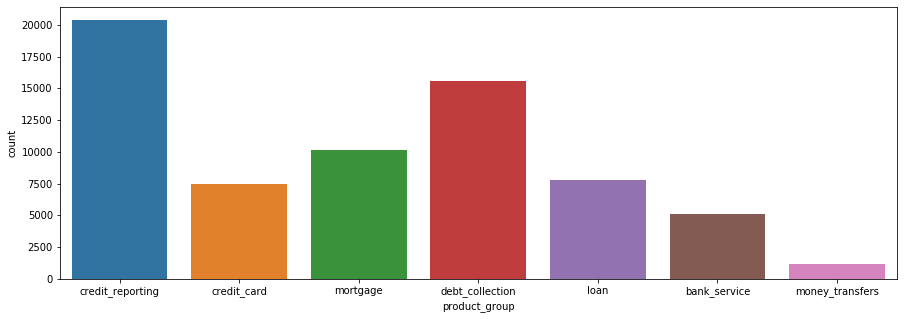

In [1143]:
# visualize the distribution of target in graph form
plt.figure(figsize = (15,5))
sns.countplot(x = 'product_group', data = df)
plt.show()

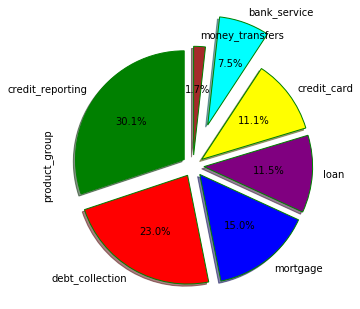

In [1144]:
# Also visualize our target variable in PIE chart form
# Creating explode data
explode = (0.1, 0.1, 0.1,0.1,0.1,0.4,0.1)
# Creating color parameters
colors = ( "green", "red", "blue","purple","yellow","cyan","brown")
  
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }


df['product_group'].value_counts().plot(kind="pie", figsize=(5,5),startangle=90,shadow=True,autopct="%1.1f%%",explode = explode,
                                   colors=colors,wedgeprops = wp)
plt.show()

# Customer complain text length distribution. Most of the customers fall around 1000-1500 text length range. It is important when you fit the CNN in order to avoid underfitting due to padding zeroes

Text(0, 0.5, 'Frequency')

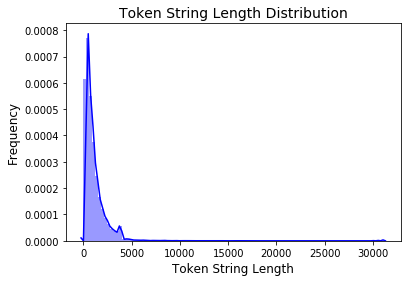

In [1145]:
sns.distplot(df['text'].str.len(),kde=True,color='blue',bins=100)
plt.title('Token String Length Distribution',fontsize=14)
plt.xlabel('Token String Length',fontsize=12)
plt.ylabel('Frequency',fontsize=12)

In [1146]:
df['text_length']  = df['text'].str.len()

In [1147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67623 entries, 109137 to 46783
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_group  67623 non-null  object
 1   text           67623 non-null  object
 2   text_length    67623 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


# Calculating the length of text WRT the product group, it does seem to vary accross product groups. It will be interesting to perform chi-squared p-value test to determine if this has any correlation with target

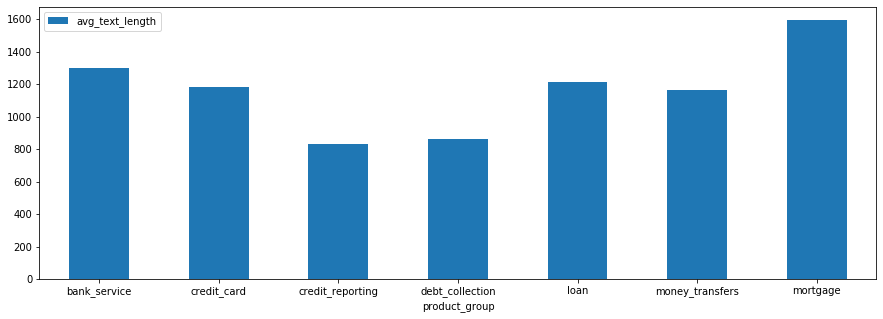

In [1148]:
df_avg_txt_len = df.groupby('product_group').agg({'text_length': ['mean']}).reset_index().rename(columns={'product_group' : 'product_group','text_length':'avg_text_leength'})
df_avg_txt_len.columns = [''] * len(df_avg_txt_len.columns)
df_avg_txt_len.columns =['product_group', 'avg_text_length']
df_avg_txt_len.plot.bar(x='product_group',y='avg_text_length',rot=0,figsize=(15, 5))

In [1149]:
# importing the NLP libraries that will be used for preprocessing
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
from nltk.stem import PorterStemmer
ps = PorterStemmer() #creating an instance of the class

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# This is a function to clean the data such as removing un-necessary punctuations, tokenizing, removing stop words for better performance and rebuilding the text

In [1150]:
# define a function for cleaning the data e.g remove stop words, digits, punctuation etc
def data_cleaning(df,column_name, full_text = False):
    stop_words=stopwords.words("english")
    cleaned_list = []
    for i in df[column_name]:
            extras = ['.',',',')','(', "'", ';','!','%','&',':','?',"#",'X','XX','XXXX','XXXXXXXX']
            res = re.sub(r'[^\w\s]', '', i) # Removing punctuations in string
            words = nltk.word_tokenize(str(res))
            without_stop_words = [word.lower() for word in words if not (word.lower() in stop_words) and (len(word)>1) if not word in extras if word.isalnum() if not word.isdigit() if len(word)>2]
            cleaned_list.append(without_stop_words)
    final = []
    for i in cleaned_list:
        for j in i:
            final.append(j)
    
    preprocess_cols = []
    if full_text == True:
        for p in cleaned_list:
            preprocess_cols.append(" ".join(p))
        return preprocess_cols
    return final

In [1151]:
# function for extracting the most common words in reviews text
def most_common_words(cleaned_col_name_list,common_words = 10):
    fdist = FreqDist(cleaned_col_name_list)
    most_common=fdist.most_common(common_words)
    return most_common

In [1152]:
# plotting the graph of most common words
def frequency_dis_graph(cleaned_col_name_list,num_of_words=10):
    fdist = FreqDist(cleaned_col_name_list)
    fdist.plot(num_of_words,cumulative=False)
    plt.show()

In [1153]:
# draw a graph of word which are most common
def word_cloud(data):
    unique_string=(" ").join(data)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("word_cloud"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

In [1154]:
# function for words in dataframe format
def table_format(data_list,column_name):
    df_ = pd.DataFrame(data_list, columns = [column_name,'Frequency_distribution'])
    return df_

In [1155]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1156]:
# calling a function

clean_df = data_cleaning(df, 'text')

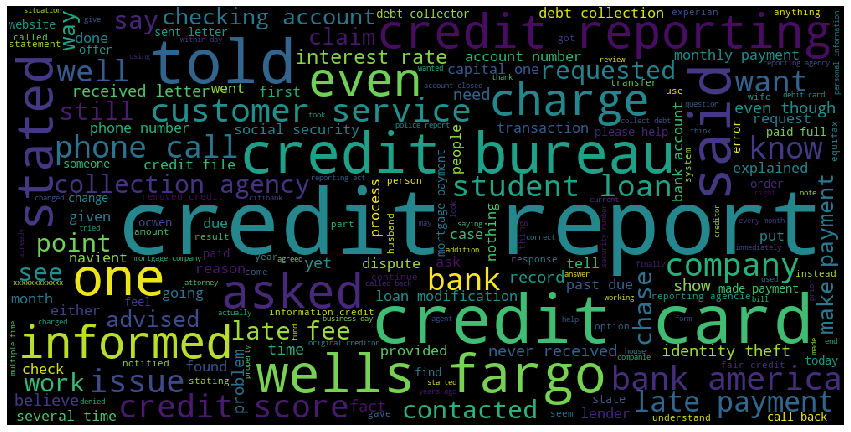

In [1157]:
# draw word cloud
word_cloud(clean_df)

In [1158]:
# lets try to check the 10 most common words
MCW = most_common_words(clean_df)
table_format(MCW, 'text')

,text,Frequency_distribution
0,credit,100567
1,account,84182
2,would,46980
3,payment,44501
4,loan,44154
5,report,41930
6,information,40301
7,bank,36433
8,debt,36355
9,told,35652


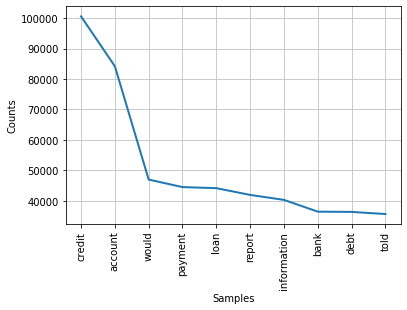

In [1159]:
# graph for showing top 10 most common words
frequency_dis_graph(clean_df)

In [1160]:
# adding a new column after preprocessing
df['preprocess_text'] = data_cleaning(df, 'text', full_text = True)

In [1161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67623 entries, 109137 to 46783
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product_group    67623 non-null  object
 1   text             67623 non-null  object
 2   text_length      67623 non-null  int64 
 3   preprocess_text  67623 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.1+ MB


# Getting the pos tags for each of the words to see if that would have any correlation with the product group
#Please note that this was run only on a fraction (5%) of  records in order to save time. Running on the whole dataset
#would take considerable amount of time
#IT WILL TAKE A LONG TIME TO RUN

In [1122]:

from collections import Counter
from itertools import chain

import pandas as pd

from nltk import word_tokenize, pos_tag

data=pd.DataFrame(df[['text','product_group']])
data.columns = ['text','tag']

tok_and_tag = lambda x: pos_tag(word_tokenize(x))

data['lower_sent'] = data['text'].apply(str.lower)
data['tagged_sent'] = data['lower_sent'].apply(tok_and_tag)

possible_tags = sorted(set(list(zip(*chain(*data['tagged_sent'])))[1]))

def add_pos_with_zero_counts(counter, keys_to_add):
    for k in keys_to_add:
        counter[k] = counter.get(k, 0)
    return counter


# Detailed steps.
data['pos_counts'] = data['tagged_sent'].apply(lambda x: Counter(list(zip(*x))[1]))
data['pos_counts_with_zero'] = data['pos_counts'].apply(lambda x: add_pos_with_zero_counts(x, possible_tags))
data['sent_vector'] = data['pos_counts_with_zero'].apply(lambda x: [count for tag, count in sorted(x.most_common())])

# All in one.
data['sent_vector'] = data['tagged_sent'].apply(lambda x:
    [count for tag, count in sorted(
        add_pos_with_zero_counts(
            Counter(list(zip(*x))[1]), 
                    possible_tags).most_common()
         )
    ]
)

data2 = pd.DataFrame(data['sent_vector'].tolist())
data2.columns = possible_tags

# Please note that this was run only on a fraction (5%) of  records in order to save time. Running on the whole dataset. Here we are getting the pos_tags and the product group into one dataframe to check if they have any correlation in future steps

In [1123]:
data3=df['product_group']
data4=data2#pos tags for each text
data3.reset_index(drop=True, inplace=True)
data4.reset_index(drop=True, inplace=True)
data6=pd.concat([data4, data3], axis=1)

In [1124]:
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12076 entries, 0 to 12075
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   #              12076 non-null  int64 
 1   $              12076 non-null  int64 
 2   ''             12076 non-null  int64 
 3   (              12076 non-null  int64 
 4   )              12076 non-null  int64 
 5   ,              12076 non-null  int64 
 6   .              12076 non-null  int64 
 7   :              12076 non-null  int64 
 8   CC             12076 non-null  int64 
 9   CD             12076 non-null  int64 
 10  DT             12076 non-null  int64 
 11  EX             12076 non-null  int64 
 12  FW             12076 non-null  int64 
 13  IN             12076 non-null  int64 
 14  JJ             12076 non-null  int64 
 15  JJR            12076 non-null  int64 
 16  JJS            12076 non-null  int64 
 17  LS             12076 non-null  int64 
 18  MD             12076 non-n

# This function will calculate the p-value using chi-squared contingency test between feature and target variable(product group). Any feature with p<=0.05 is significant

In [1125]:
#Lets create a function that would provide chi-squared p value.
#This explains the significance of the feature variable (pos tags) with respect to the target variable which is 
#"product grouping"
#p values less than 0.05 can be used as features

from scipy.stats import chi2,chi2_contingency
def explore_attribute(metricname, data7):
    print('---------------%s-------------------' %metricname)
    f, axes = plt.subplots(1,2)
    sns.countplot(x=metricname,data=data7[[metricname,"product_group"]],ax=axes[0])
    
    sns.barplot(x=metricname,
               y='product_group',
               palette='Blues',
               data=data7[[metricname,"product_group"]],ax=axes[1])
    contingency=pd.crosstab(data7[metricname],data7["product_group"])
    print(contingency)
    c,p,dof,expected=chi2_contingency(contingency)
    print('p-value=%s' %p)
    if p<0.05:
        print('Include This Variable')
    else:
        print('Do not Include This Variable')
    print('--------------------END-------------------')
            

In [1126]:
pos_cols=["CD","DT","EX","FW","IN","JJ","JJR","JJS","LS","MD","NN","NNP","NNPS","NNS","PDT","POS","PRP","RB","RBR","RBS","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP","WRB"]

In [1127]:
# Now let us explore each of the pos tags to find out if any of them have correlation with "product grouping"

# Please note that this was run only on a fraction (5%) of  records in order to save time. Running on the whole dataset will take long time. This can be skipped. Here we observed a lot of pos tags have a very high correlation with product group

---------------CD-------------------
product_group  bank_service  credit_card  credit_reporting  debt_collection  \
CD                                                                            
0                       191          267              1425             1138   
1                       159          227               791              634   
2                       140          179               445              329   
3                       115          139               326              221   
4                        73          109               206              132   
5                        48           89               115               97   
6                        44           66                91               57   
7                        43           56                61               48   
8                        21           34                54               24   
9                        20           33                39               27   
10             

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
EX                                                                            
0                       678          958              3021             2353   
1                       177          247               517              339   
2                        48           78               114               64   
3                        30           29                33               16   
4                         5            4                 9                6   
5                         3            8                 2                2   
6                         1            0                 2                1   
7                         0            1                 0                0   
8                         0            0                 0                1   
9                         1            1                 0                0   
10                        0            0            

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
JJS                                                                           
0                       837         1146              3453             2603   
1                        85          130               210              151   
2                        12           28                19               19   
3                         5           14                11               10   
4                         3            4                 2                0   
5                         1            1                 1                0   
6                         0            1                 1                0   
7                         0            1                 0                0   
8                         0            1                 1                0   
9                         0            0                 1                0   

product_group  loan  money_transfers  mortgage  
JJ

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
NNP                                                                           
0                       269          416              1193              994   
1                       122          182               439              343   
2                       114          152               376              273   
3                        73          103               270              197   
4                        61          105               213              168   
..                      ...          ...               ...              ...   
212                       0            0                 1                0   
216                       0            1                 0                0   
245                       0            0                 1                0   
311                       0            0                 1                0   
343                       0            0            

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
RB                                                                            
0                        35           40               296              184   
1                        62           89               467              292   
2                        69           85               411              295   
3                        57           93               336              281   
4                        67           99               357              235   
..                      ...          ...               ...              ...   
145                       0            0                 1                0   
158                       0            1                 0                0   
179                       0            1                 0                0   
180                       0            0                 0                0   
208                       0            1            

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
TO                                                                            
0                        64           98               588              295   
1                        84          128               566              382   
2                        90          139               497              374   
3                        75          119               416              335   
4                        86          123               326              252   
..                      ...          ...               ...              ...   
87                        0            0                 1                0   
93                        0            1                 0                0   
99                        0            0                 0                0   
101                       0            1                 0                0   
118                       0            0            

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
VBN                                                                           
0                        66           64               372              251   
1                        66          113               416              377   
2                        89          118               464              374   
3                        83          132               428              312   
4                        77          112               335              263   
..                      ...          ...               ...              ...   
85                        0            0                 0                0   
87                        0            1                 0                0   
94                        0            1                 0                0   
109                       0            0                 0                0   
138                       0            0            

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
VBZ                                                                           
0                       167          254               739              530   
1                       186          242               769              625   
2                       117          193               622              472   
3                       131          154               405              348   
4                        68          112               316              218   
5                        71           91               237              161   
6                        41           57               141              115   
7                        30           50               113               78   
8                        34           34                69               60   
9                        30           28                66               39   
10                       17           26            

product_group  bank_service  credit_card  credit_reporting  debt_collection  \
WP                                                                            
0                       584          859              2937             1970   
1                       207          268               511              483   
2                        77          105               151              204   
3                        36           48                51               67   
4                        17           17                32               30   
5                        11           12                 4               12   
6                         5            9                 7               11   
7                         4            3                 4                3   
8                         1            0                 1                1   
9                         1            2                 0                0   
10                        0            0            

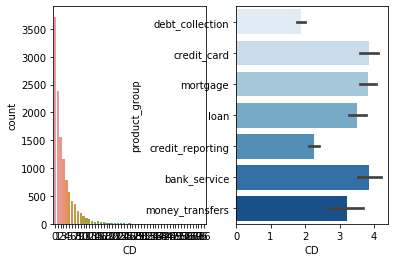

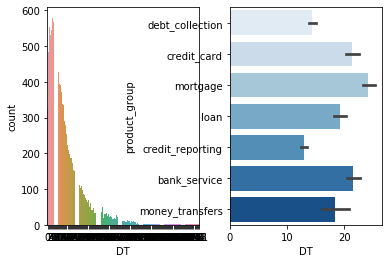

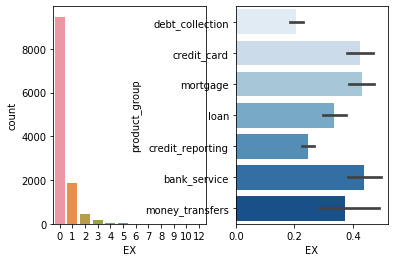

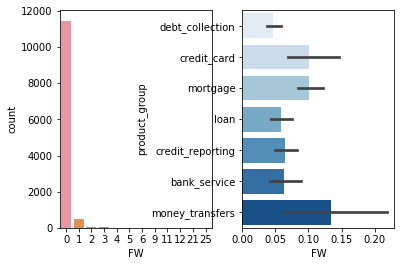

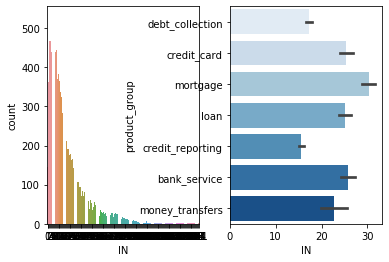

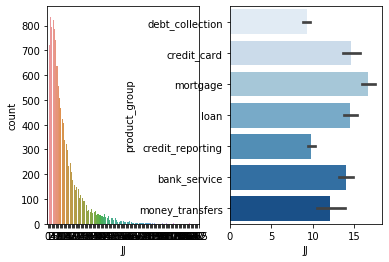

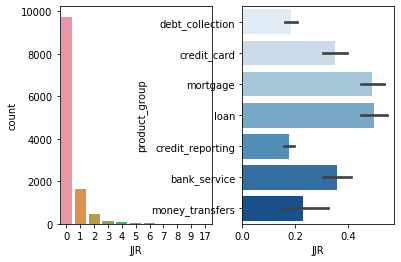

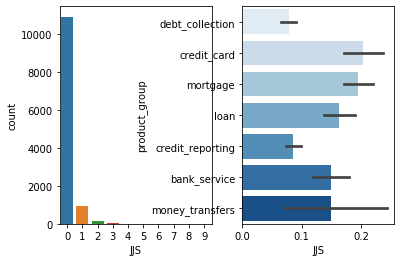

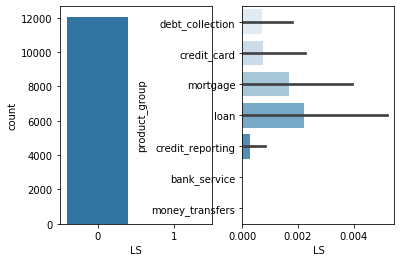

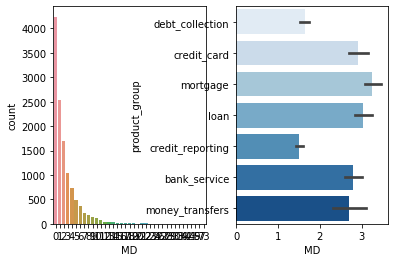

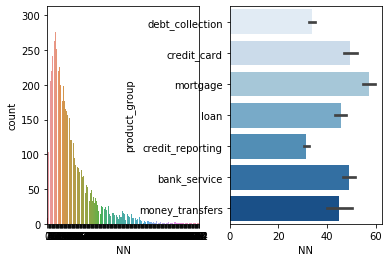

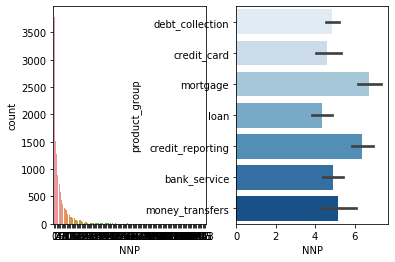

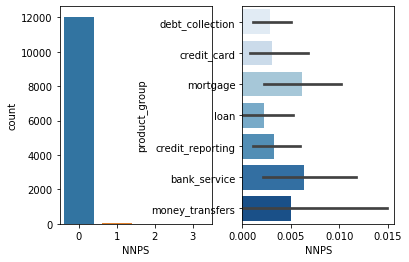

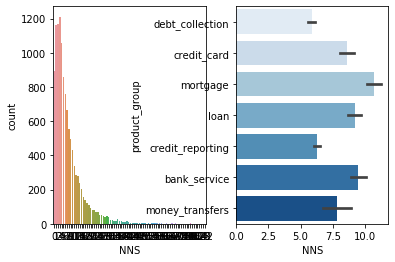

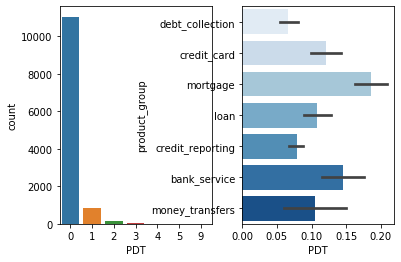

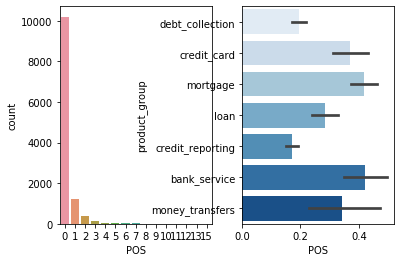

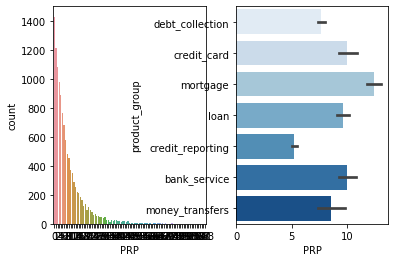

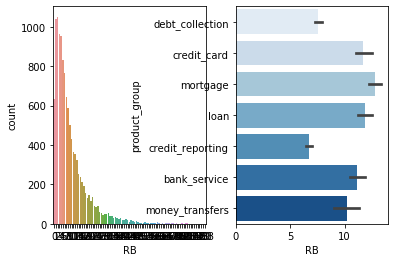

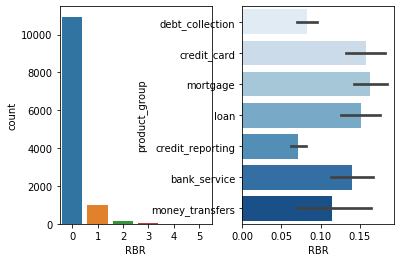

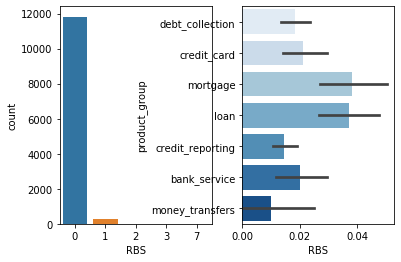

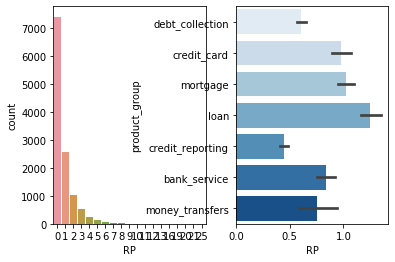

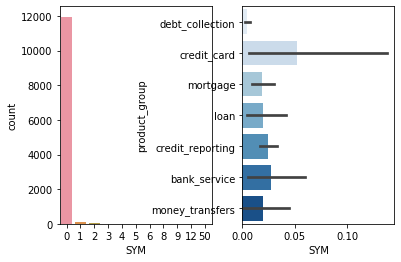

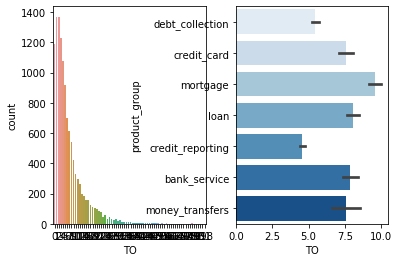

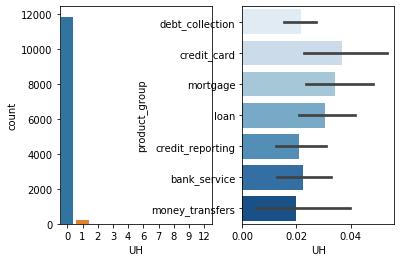

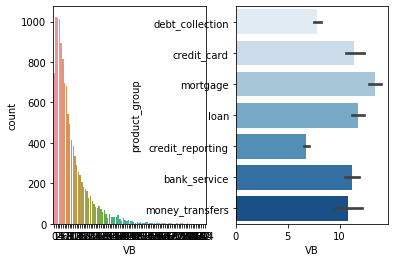

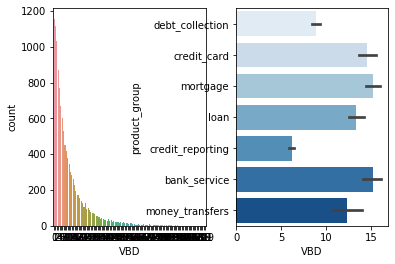

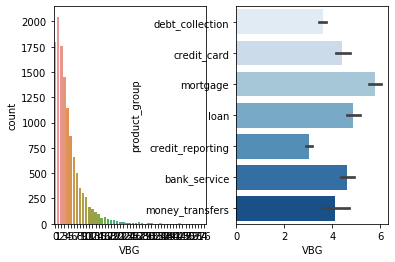

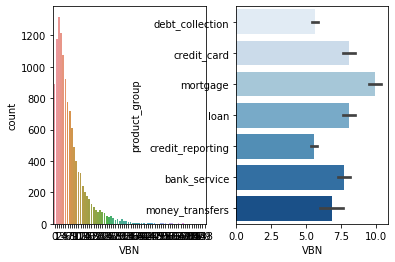

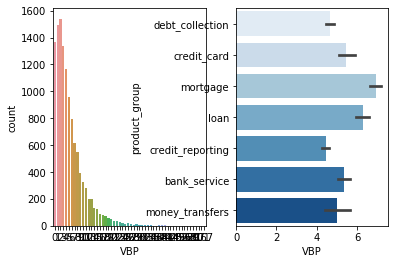

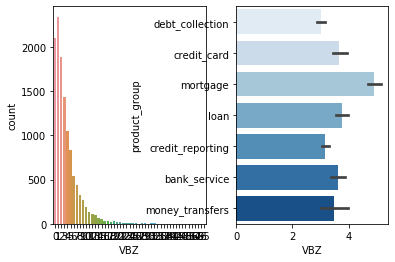

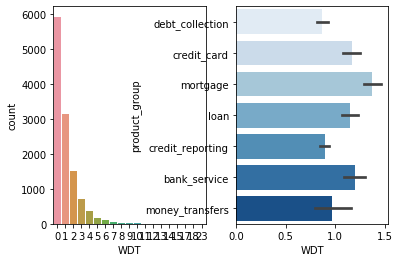

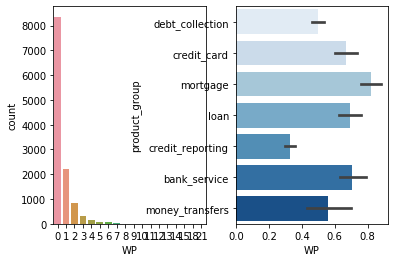

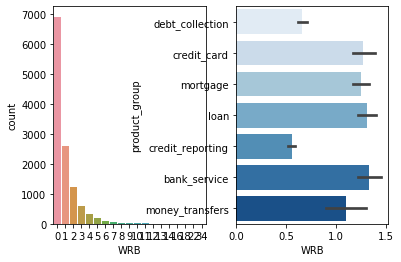

In [1128]:
for features in pos_cols:
    explore_attribute(features,data6)

---------------text_length-------------------
product_group  bank_service  credit_card  credit_reporting  debt_collection  \
text_length                                                                   
52                        0            0                 1                0   
58                        0            0                 0                0   
60                        1            0                 0                0   
67                        0            0                 0                0   
74                        0            0                 0                1   
...                     ...          ...               ...              ...   
4876                      0            0                 0                1   
5006                      0            0                 0                1   
5257                      0            0                 0                1   
5317                      1            0                 0                0   
8607  

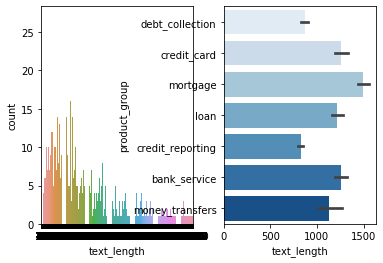

In [1129]:
#Lets also explore the significance of test length wrt "product_grouping"
explore_attribute('text_length',df)

# This is model evaluation function for future model runs

In [1162]:
# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set, model_name):
    # Print model evaluation to predicted result    
    start_time = time.time()
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    print ("Precision on validation set: {:.4f}".format(precision_score(y_test_set, predictions, average='macro')))    
    print ("Recall on validation set: {:.4f}".format(recall_score(y_test_set, predictions, average='macro')))
    print ("F1_Score on validation set: {:.4f}".format(f1_score(y_test_set, predictions, average='macro')))
    print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    cm = confusion_matrix(y_test_set, predictions)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(7, 7)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    end = round(time.time()-start_time,3)
    results = [accuracy_score(y_test_set, predictions),precision_score(y_test_set, predictions, average='macro'),
              recall_score(y_test_set, predictions, average='macro'),f1_score(y_test_set, predictions, average='macro'),end]
    return results

# Please note that this was run only on a fraction (5%) of  records in order to save time. Running on the whole dataset will take long time. This can be skipped. Here we are using count_vectorizer, tf_idf on top of it, also lenght of the text and also noun pos tagging to see how the model will perform. It gives 54% accuracy on 5% data with Multinomial Naive Bayes algorithm

========== mnb ==========

Accuracy on validation set: 0.5462
Precision on validation set: 0.5966
Recall on validation set: 0.3481
F1_Score on validation set: 0.3065

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.71      0.02      0.03       282
     credit_card       0.71      0.03      0.06       404
credit_reporting       0.46      0.97      0.63      1096
 debt_collection       0.82      0.51      0.63       811
            loan       0.87      0.05      0.09       413
 money_transfers       0.00      0.00      0.00        77
        mortgage       0.60      0.86      0.71       540

        accuracy                           0.55      3623
       macro avg       0.60      0.35      0.31      3623
    weighted avg       0.65      0.55      0.46      3623


Confusion Matrix : 
 [[   5    5  187    7    1    0   77]
 [   1   12  339   15    0    0   37]
 [   0    0 1066   16    1    0   13]
 [   0    0  365  411    1    

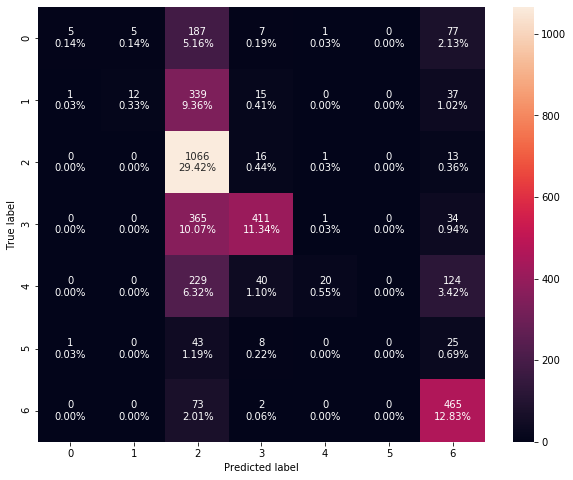

In [1131]:
#Lets build the model using the sklearn pipeline using countvectorizor, tf-idf, length of the string, and noun pos tagging
# We can as well use the other pos tags but the important thing is figure out if they would add any noise
# Lets use pos tag of NOUN and length to start with
from sklearn.model_selection import train_test_split
from collections import Counter
def get_text_length(x):
    return np.array([len(t) for t in x.str.split()]).reshape(-1, 1)

def get_pos_tags(x):
  output = []
  for i in x:
    tokens = nltk.word_tokenize(i.lower())
    i = nltk.Text(tokens)
    tags = nltk.pos_tag(i)
    counts = Counter(tag for word,tag in tags)
    counts1=counts['NN']
    output.append(counts1)
  return np.array([t for t in output]).reshape(-1, 1)

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
        ])),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ])),
        ('POS_VEC', Pipeline([
            ('POS_VEC', FunctionTransformer(get_pos_tags, validate=False)),
        ]))
    ])),
    ('classifier', MultinomialNB())])

x_train, x_test, y_train, y_test = train_test_split(df['preprocess_text'], df['product_group'], test_size=0.3, random_state=42)

pred=classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
predicted
results_mnb = modelEvaluation(predicted, y_test, "mnb")

# Running with only the count vectorizer, tf idf, length of string to see the results. Th results are similar. Only slightly better than earlier (56.33% vs 56.28%)

========== mnb ==========

Accuracy on validation set: 0.5501
Precision on validation set: 0.6058
Recall on validation set: 0.3519
F1_Score on validation set: 0.3122

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.71      0.02      0.03       282
     credit_card       0.75      0.04      0.07       404
credit_reporting       0.47      0.97      0.63      1096
 debt_collection       0.82      0.51      0.63       811
            loan       0.89      0.06      0.11       413
 money_transfers       0.00      0.00      0.00        77
        mortgage       0.59      0.86      0.70       540

        accuracy                           0.55      3623
       macro avg       0.61      0.35      0.31      3623
    weighted avg       0.66      0.55      0.46      3623


Confusion Matrix : 
 [[   5    5  182    6    1    0   83]
 [   1   15  332   17    0    0   39]
 [   0    0 1066   16    1    0   13]
 [   0    0  356  417    1    

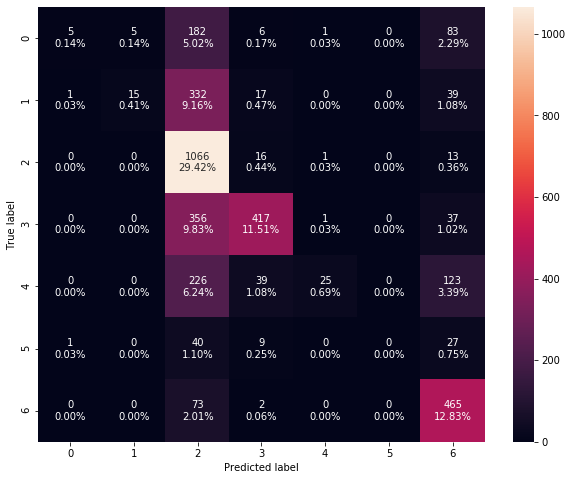

In [1132]:
from sklearn.model_selection import train_test_split
from collections import Counter
def get_text_length(x):
    return np.array([len(t) for t in x.str.split()]).reshape(-1, 1)

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
        ])),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('classifier', MultinomialNB())])

x_train, x_test, y_train, y_test = train_test_split(df['preprocess_text'], df['product_group'], test_size=0.3, random_state=42)

pred=classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
predicted
results_mnb = modelEvaluation(predicted, y_test, "mnb")

# Running with only the count vectorizer. Apparently the length of string and the pos tag for Noun were adding noise to the model. Accuracy improved from 56 to 66

========== mnb ==========

Accuracy on validation set: 0.6506
Precision on validation set: 0.6791
Recall on validation set: 0.4632
F1_Score on validation set: 0.4861

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.89      0.18      0.30       282
     credit_card       0.78      0.25      0.38       404
credit_reporting       0.54      0.97      0.69      1096
 debt_collection       0.69      0.70      0.70       811
            loan       0.96      0.33      0.49       413
 money_transfers       0.00      0.00      0.00        77
        mortgage       0.89      0.82      0.85       540

        accuracy                           0.65      3623
       macro avg       0.68      0.46      0.49      3623
    weighted avg       0.72      0.65      0.61      3623


Confusion Matrix : 
 [[  50   22  150   44    1    0   15]
 [   1  101  238   61    0    0    3]
 [   0    0 1059   33    1    0    3]
 [   0    0  228  570    3    

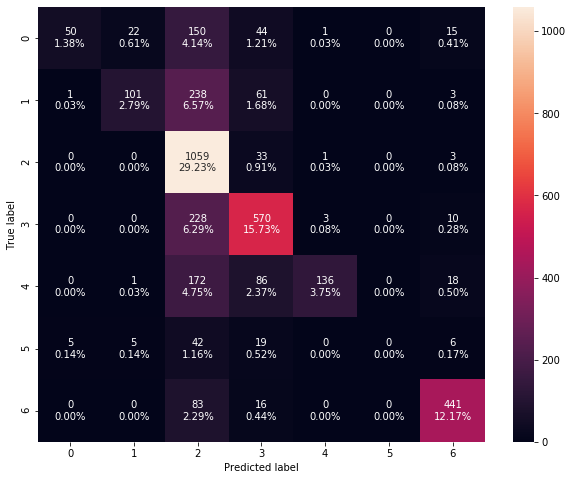

In [1133]:
#Running with only the count vectorizer
#Apparently the length of string and the pos tag for Noun were adding noise to the model
#Accuracy improved from 56 to 66
from sklearn.model_selection import train_test_split
from collections import Counter

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
        ]))
    ])),
    ('classifier', MultinomialNB())])

x_train, x_test, y_train, y_test = train_test_split(df['preprocess_text'], df['product_group'], test_size=0.3, random_state=42)

pred=classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
predicted
results_mnb = modelEvaluation(predicted, y_test, "mnb")

# Running with only the count vectorizer, tf idf with unigrams. But this time LinearSVC. The accurac is 80%

========== mnb ==========

Accuracy on validation set: 0.7996
Precision on validation set: 0.7902
Recall on validation set: 0.7349
F1_Score on validation set: 0.7532

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.74      0.74      0.74       282
     credit_card       0.75      0.74      0.74       404
credit_reporting       0.81      0.84      0.83      1096
 debt_collection       0.79      0.81      0.80       811
            loan       0.77      0.72      0.74       413
 money_transfers       0.79      0.40      0.53        77
        mortgage       0.88      0.89      0.88       540

        accuracy                           0.80      3623
       macro avg       0.79      0.73      0.75      3623
    weighted avg       0.80      0.80      0.80      3623


Confusion Matrix : 
 [[209  28  14  10   7   6   8]
 [ 28 299  40  19  11   2   5]
 [  6  30 925  78  36   0  21]
 [ 14  11  94 657  20   0  15]
 [  3  15  40  46 29

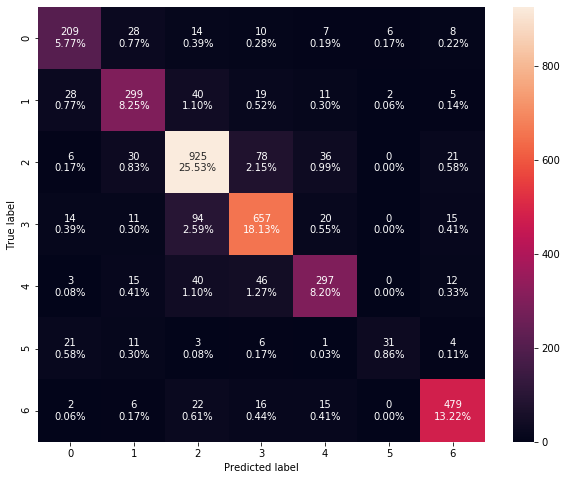

In [1134]:
from sklearn.model_selection import train_test_split
from collections import Counter

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
        ]))
    ])),
    ('classifier', LinearSVC())])

x_train, x_test, y_train, y_test = train_test_split(df['preprocess_text'], df['product_group'], test_size=0.3, random_state=42)

pred=classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
predicted
results_mnb = modelEvaluation(predicted, y_test, "mnb")

# Running with only the count vectorizer, tf idf with bigrams with LinearSVC. The accuracy increased to 82%

0.81810654154016
========== linear SVC ==========

Accuracy on validation set: 0.8181
Precision on validation set: 0.8153
Recall on validation set: 0.7543
F1_Score on validation set: 0.7738

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.73      0.75      0.74       282
     credit_card       0.77      0.77      0.77       404
credit_reporting       0.83      0.87      0.85      1096
 debt_collection       0.82      0.82      0.82       811
            loan       0.81      0.73      0.77       413
 money_transfers       0.87      0.43      0.57        77
        mortgage       0.88      0.91      0.89       540

        accuracy                           0.82      3623
       macro avg       0.82      0.75      0.77      3623
    weighted avg       0.82      0.82      0.82      3623


Confusion Matrix : 
 [[212  29  16   8   3   4  10]
 [ 23 313  34  20   6   1   7]
 [  7  27 950  60  35   0  17]
 [ 12  10  90 664  15   0  

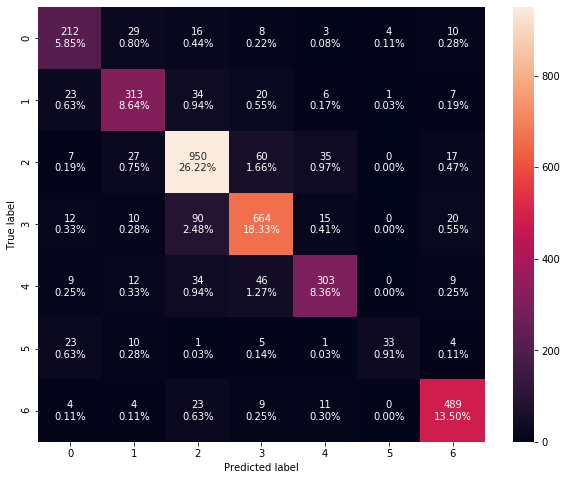

In [1163]:

LSVC = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),('classifier', LinearSVC())])
LSVC.fit(x_train, y_train)
accuracy = str(LSVC.score(x_test, y_test))
print(accuracy)
predicted = LSVC.predict(x_test)
results_lsvc = modelEvaluation(predicted, y_test, "linear SVC")

In [1164]:
#Now lets try tf_idf on other algorithms

In [1165]:
# Import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import time

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [1166]:
# Fit and transform the training data to a document-term matrix using just the TfidfVectorizer 
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train.values)
print ("Number of features : %d" %len(tfidf.get_feature_names()))

Number of features : 20234


# LOGISTIC REGRESSION

========== logistic Regression ==========

Accuracy on validation set: 0.8057
Precision on validation set: 0.8081
Recall on validation set: 0.7315
F1_Score on validation set: 0.7554

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.75      0.73      0.74       282
     credit_card       0.77      0.74      0.75       404
credit_reporting       0.80      0.87      0.83      1096
 debt_collection       0.79      0.81      0.80       811
            loan       0.80      0.72      0.76       413
 money_transfers       0.85      0.36      0.51        77
        mortgage       0.90      0.89      0.90       540

        accuracy                           0.81      3623
       macro avg       0.81      0.73      0.76      3623
    weighted avg       0.81      0.81      0.80      3623


Confusion Matrix : 
 [[206  29  21  13   4   4   5]
 [ 25 297  46  24   8   1   3]
 [  4  25 952  66  32   0  17]
 [ 11  10  98 656  18   0  18]
 [  

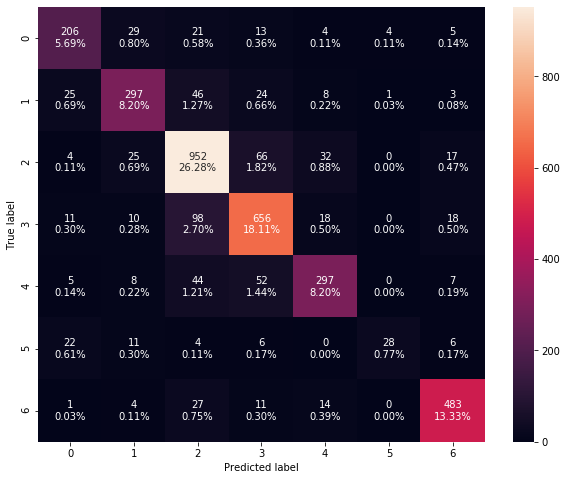

In [1174]:
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)
predictions = lr.predict(tfidf.transform(x_test))
results_lr = modelEvaluation(predictions, y_test, "logistic Regression")

### SAVE MODEL TO PREDICT UNSEEN DATA USING LOGISTIC REGRESSION

In [1181]:
# save the model to disk
import pickle
filename = 'loaded_model_lr.sav'
pickle.dump(lr, open(filename, 'wb'))

In [1182]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [1183]:
unseen_load = pd.read_csv('unseen-data.csv');

In [1184]:
unseen_load.head()

,complaint_id,product_group,text
0,1576257,debt_collection,"XXXX XXXX, for XXXX XXXX XXXX XXXX XXXX, Tx ca..."
1,2739757,loan,My load was from XXXX XXXX to go to school at ...
2,1751281,credit_card,"In XXXX 2014, I purchased windows from The Hom..."
3,2800027,mortgage,I have a mortgage with PHH Mortgage Service th...
4,2274991,credit_reporting,I requested a dispute with MIB about the infor...


In [1185]:
# Select a random record from unseen-data.csv to predict unseen text
random_unseen_test_data = unseen_load.sample()
sample_unseen_text = random_unseen_test_data['text'].values

In [1186]:
X_unseen = tfidf.transform(sample_unseen_text).toarray()
y_pred = loaded_model.predict(X_unseen)

print("Actual data", random_unseen_test_data['product_group'].values)
print("Predicted complaint type: " + y_pred)

Actual data ['credit_card']
['Predicted complaint type: credit_card']


# MODEL FOR SVC. The accuracy here is 81% with 25% data but when ran with entire dataset  it is 87%

========== SVM ==========

Accuracy on validation set: 0.8096
Precision on validation set: 0.8152
Recall on validation set: 0.7314
F1_Score on validation set: 0.7539

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.73      0.74      0.73       282
     credit_card       0.77      0.76      0.76       404
credit_reporting       0.81      0.87      0.84      1096
 debt_collection       0.79      0.82      0.81       811
            loan       0.81      0.72      0.76       413
 money_transfers       0.89      0.32      0.48        77
        mortgage       0.91      0.89      0.90       540

        accuracy                           0.81      3623
       macro avg       0.82      0.73      0.75      3623
    weighted avg       0.81      0.81      0.81      3623


Confusion Matrix : 
 [[208  31  19  12   5   3   4]
 [ 26 306  40  24   5   0   3]
 [  5  26 950  67  33   0  15]
 [ 12  12  91 663  17   0  16]
 [  5  10  44  49 29

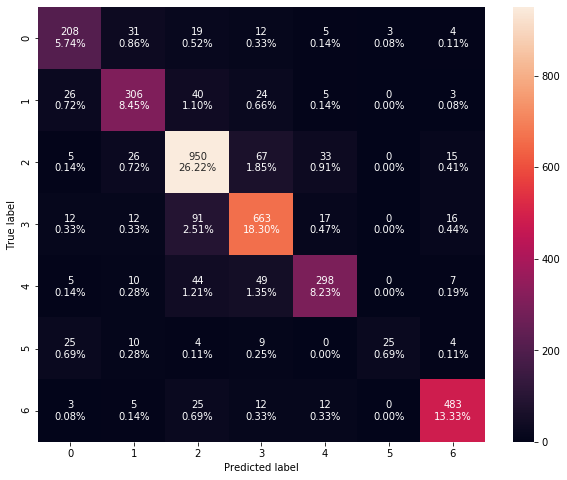

In [1187]:
svc = SVC()
svc.fit(x_train_tfidf, y_train)
predictions = svc.predict(tfidf.transform(x_test))
results_svc = modelEvaluation(predictions, y_test, "SVM")

### SAVE MODEL TO PREDICT UNSEEN DATA USING SVC

In [1188]:
# save the model to disk
import pickle
filename = 'loaded_model_svm.sav'
pickle.dump(svc, open(filename, 'wb'))

In [1189]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [1190]:
unseen_load = pd.read_csv('unseen-data.csv');

In [1191]:
unseen_load.head()

,complaint_id,product_group,text
0,1576257,debt_collection,"XXXX XXXX, for XXXX XXXX XXXX XXXX XXXX, Tx ca..."
1,2739757,loan,My load was from XXXX XXXX to go to school at ...
2,1751281,credit_card,"In XXXX 2014, I purchased windows from The Hom..."
3,2800027,mortgage,I have a mortgage with PHH Mortgage Service th...
4,2274991,credit_reporting,I requested a dispute with MIB about the infor...


In [1192]:
# Select a random record from unseen-data.csv to predict unseen text
random_unseen_test_data = unseen_load.sample()
sample_unseen_text = random_unseen_test_data['text'].values

In [1193]:
X_unseen = tfidf.transform(sample_unseen_text).toarray()
y_pred = loaded_model.predict(X_unseen)

print("Actual data", random_unseen_test_data['product_group'].values)
print("Predicted complaint type: " + y_pred)

Actual data ['debt_collection']
['Predicted complaint type: debt_collection']


## Model Building - Multinomial Navie Bayes

========== Multinomial NB ==========

Accuracy on validation set: 0.6506
Precision on validation set: 0.6791
Recall on validation set: 0.4632
F1_Score on validation set: 0.4861

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.89      0.18      0.30       282
     credit_card       0.78      0.25      0.38       404
credit_reporting       0.54      0.97      0.69      1096
 debt_collection       0.69      0.70      0.70       811
            loan       0.96      0.33      0.49       413
 money_transfers       0.00      0.00      0.00        77
        mortgage       0.89      0.82      0.85       540

        accuracy                           0.65      3623
       macro avg       0.68      0.46      0.49      3623
    weighted avg       0.72      0.65      0.61      3623


Confusion Matrix : 
 [[  50   22  150   44    1    0   15]
 [   1  101  238   61    0    0    3]
 [   0    0 1059   33    1    0    3]
 [   0    0  228  5

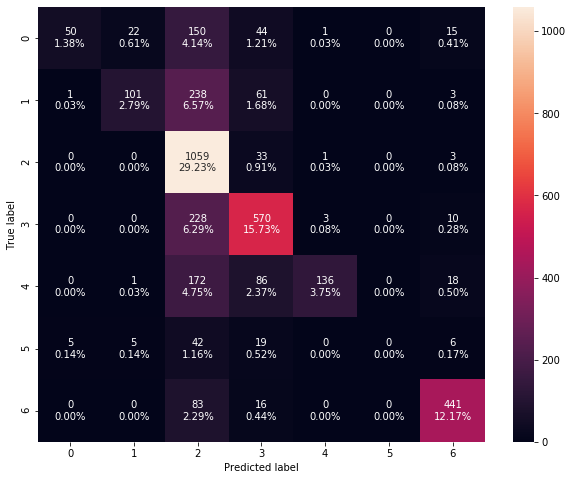

In [1194]:
gnb = MultinomialNB()
gnb.fit(x_train_tfidf, y_train)
predictions = gnb.predict(tfidf.transform(x_test))
results_gnb = modelEvaluation(predictions, y_test, "Multinomial NB")

# RANDOM FORESTS

========== RandomForestClassifier ==========

Accuracy on validation set: 0.7795
Precision on validation set: 0.8273
Recall on validation set: 0.6558
F1_Score on validation set: 0.6808

Classification report : 
                   precision    recall  f1-score   support

    bank_service       0.77      0.65      0.71       282
     credit_card       0.80      0.68      0.73       404
credit_reporting       0.75      0.91      0.82      1096
 debt_collection       0.75      0.80      0.77       811
            loan       0.88      0.60      0.71       413
 money_transfers       1.00      0.09      0.17        77
        mortgage       0.85      0.87      0.86       540

        accuracy                           0.78      3623
       macro avg       0.83      0.66      0.68      3623
    weighted avg       0.79      0.78      0.77      3623


Confusion Matrix : 
 [[ 184   30   33   22    3    0   10]
 [  11  273   73   36    5    0    6]
 [   3    9 1000   64    9    0   11]
 [   4    8

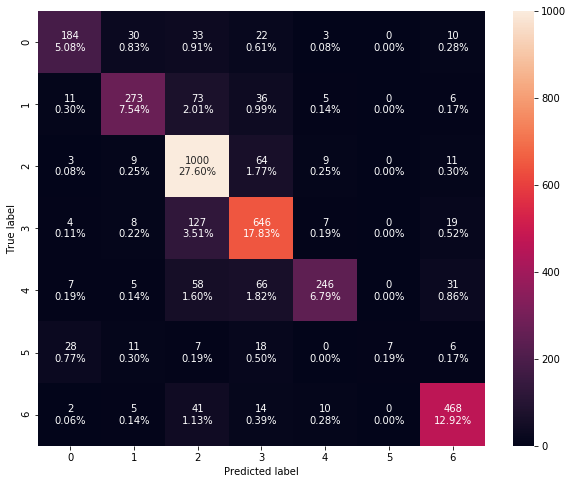

In [1195]:
rf = RandomForestClassifier()
rf.fit(x_train_tfidf, y_train)
predictions = rf.predict(tfidf.transform(x_test))
results_rf = modelEvaluation(predictions, y_test, "RandomForestClassifier")

# CNN. I have choosen CNN Purely based on prior experiences. I was hoping this would give the best performance but since it used only 25% of data, the accurancy was (81%) which was lower than SVM which used 100% and generated 87% accuracy

In [1196]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df_cnn=df
df_cnn['product_group']= label_encoder.fit_transform(df_cnn['product_group'])

df_cnn['product_group'].unique()

array([2, 1, 6, 3, 4, 0, 5])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_cnn['preprocess_text'], df_cnn['product_group'], test_size=0.3, random_state=42)

In [720]:
#Fitting the CNN
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
Xcnn_train = tokenizer.texts_to_sequences(x_train)
Xcnn_test = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1  

In [721]:
# Get max training sequence length
maxlen = max([len(x) for x in Xcnn_train])
maxlen

2606

In [722]:
from keras.preprocessing.sequence import pad_sequences
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)

In [723]:
from keras.models import Sequential
from keras import layers

In [724]:
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(128, 5, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(10, activation='relu'))
textcnnmodel.add(layers.Dense(7, activation='softmax'))
textcnnmodel.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
textcnnmodel.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2606, 200)         4184800   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2602, 128)         128128    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 77        
Total params: 4,314,295
Trainable params: 4,314,295
Non-trainable params: 0
_________________________________________________________________


In [725]:
#Defining model fit parameters
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_weights.hdf5',verbose=0, save_best_only=True)

In [726]:
history = textcnnmodel.fit(Xcnn_train, y_train, epochs=2,
                     validation_data=(Xcnn_test, y_test))

Train on 9391 samples, validate on 4026 samples
Epoch 1/2
9391/9391 [==============================] - 261s 28ms/step - loss: 1.1219 - accuracy: 0.5981 - val_loss: 0.6998 - val_accuracy: 0.7668
Epoch 2/2
9391/9391 [==============================] - 264s 28ms/step - loss: 0.5214 - accuracy: 0.8289 - val_loss: 0.6145 - val_accuracy: 0.7931


In [728]:
history = textcnnmodel.fit(Xcnn_train, y_train, callbacks=[monitor, checkpointer],
                     validation_data=(Xcnn_test, y_test), batch_size = 128, epochs=10) 

Train on 9391 samples, validate on 4026 samples
Epoch 1/10
9391/9391 [==============================] - 255s 27ms/step - loss: 0.2827 - accuracy: 0.9212 - val_loss: 0.5965 - val_accuracy: 0.8035
Epoch 2/10
9391/9391 [==============================] - 252s 27ms/step - loss: 0.2070 - accuracy: 0.9478 - val_loss: 0.6095 - val_accuracy: 0.8030
Epoch 3/10
9391/9391 [==============================] - 247s 26ms/step - loss: 0.1515 - accuracy: 0.9659 - val_loss: 0.6233 - val_accuracy: 0.8020
Epoch 4/10
9391/9391 [==============================] - 248s 26ms/step - loss: 0.1079 - accuracy: 0.9789 - val_loss: 0.6495 - val_accuracy: 0.7991
Epoch 5/10
9391/9391 [==============================] - 255s 27ms/step - loss: 0.0755 - accuracy: 0.9885 - val_loss: 0.6723 - val_accuracy: 0.7981
Epoch 6/10
9391/9391 [==============================] - 257s 27ms/step - loss: 0.0532 - accuracy: 0.9930 - val_loss: 0.7012 - val_accuracy: 0.7961
Epoch 7/10
9391/9391 [==============================] - 237s 25ms/step

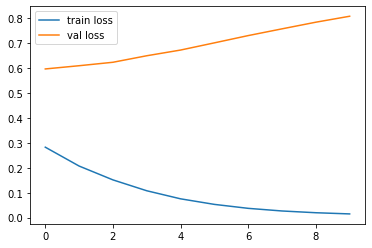

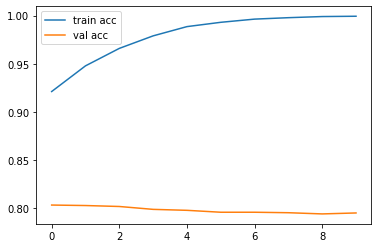

<Figure size 432x288 with 0 Axes>

In [729]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [735]:
y_preds = textcnnmodel.predict(Xcnn_test)
y_pred_labels = [np.argmax(pred,axis=0) for pred in y_preds]

========== Convolutional Neural Network ==========

Accuracy on validation set: 0.7953
Precision on validation set: 0.7653
Recall on validation set: 0.7503
F1_Score on validation set: 0.7569

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.74      0.73       296
           1       0.74      0.74      0.74       455
           2       0.83      0.82      0.82      1211
           3       0.79      0.81      0.80       933
           4       0.73      0.71      0.72       440
           5       0.67      0.55      0.61        78
           6       0.88      0.87      0.88       613

    accuracy                           0.80      4026
   macro avg       0.77      0.75      0.76      4026
weighted avg       0.80      0.80      0.80      4026


Confusion Matrix : 
 [[220  40  13   0   5   7  11]
 [ 25 338  39  37   7   5   4]
 [  9  39 996 102  36   0  29]
 [  7  24  83 760  43   3  13]
 [  6   9  51  47 311   4  12]
 [ 20   

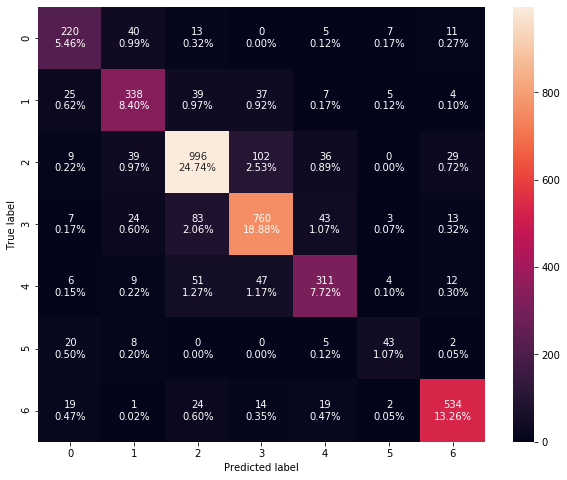

In [731]:
results_cnn = modelEvaluation(y_pred_labels,y_test,'Convolutional Neural Network')

# Glove with CNN. Using a Glove embedding layer should improve the accuracy of the model.

In [1197]:
#load pre-trained word vectors
import os
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dense,Input, GlobalMaxPooling1D
from keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

In [1198]:
#configuration
MAX_SEQUENCE_LENGTH=2500
MAX_VOCAB_SIZE=50000
EMBEDDING_DIM=100
VALIDATION_SPLIT=0.3
BATCH_SIZE=128
EPOCHS=10

In [1199]:
#load pre-trained word vectors
print("Loading word vectors...")
word2vec={}
with open("glove.6B.100d.txt",encoding="utf8") as f:
 for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print("Found %s word vectors." % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [1200]:
sentences = df["text"].fillna("DUMMY_VALUE").values
targets = pd.get_dummies(df['product_group']).values
coding_seq = pd.get_dummies(df['product_group'])
coding_dict = {coding_seq.columns.get_loc(i):i for i in coding_seq.columns}
label_cnt = len(df.product_group.unique())
print('max sequence length:', max(len(s) for s in sentences))
print('min sequence length:', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s)//2])

max sequence length: 31047
min sequence length: 8
median sequence length: 741


In [1202]:
sentences

array(['I have several accounts that are not mine that i continue to have reporting to my credit file i am submitting a new police report that has these accounts added to them so that you can identify them along with a ftc affidavit that has been notarized. still these accounts have not been removed as they are fraudulent',
       "A credit card was made out in my name and former company and mailed to my former address. A man claiming to be me knocked on my neighbor 's door and requested the credit card envelope. Simultaneously, all of my mail at my current address had been put on hold for two weeks by an unknown source.",
       "I was going through my credit report and noticed same items that i been trying to dispute and validate with the credit bureaus ( transunion, XXXX, and XXXX ), and the original creditors, debt collectors, collections, etc, but yet to be resolved. I've attempted to contacted them several times through mail, and phone calls, but yet to get them resolved. I've ha

In [1203]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [1204]:
word2idx=tokenizer.word_index
print("Found %s unique tokens." % len(word2idx))

Found 49684 unique tokens.


In [1205]:
word2idx

{'xxxx': 1,
 'the': 2,
 'i': 3,
 'to': 4,
 'and': 5,
 'my': 6,
 'a': 7,
 'of': 8,
 'that': 9,
 'was': 10,
 'in': 11,
 'xx': 12,
 'they': 13,
 'on': 14,
 'have': 15,
 'this': 16,
 'not': 17,
 'for': 18,
 'is': 19,
 'me': 20,
 'with': 21,
 'credit': 22,
 'it': 23,
 'account': 24,
 'from': 25,
 'as': 26,
 '00': 27,
 'be': 28,
 'had': 29,
 'them': 30,
 'by': 31,
 'would': 32,
 'or': 33,
 'are': 34,
 'payment': 35,
 'loan': 36,
 'an': 37,
 'been': 38,
 'at': 39,
 'no': 40,
 'report': 41,
 'we': 42,
 'has': 43,
 'information': 44,
 'but': 45,
 'all': 46,
 'did': 47,
 'bank': 48,
 'debt': 49,
 'do': 50,
 'told': 51,
 'which': 52,
 'any': 53,
 'am': 54,
 'you': 55,
 'were': 56,
 'received': 57,
 'their': 58,
 'when': 59,
 'company': 60,
 'time': 61,
 'so': 62,
 'called': 63,
 'card': 64,
 'if': 65,
 'after': 66,
 'never': 67,
 "n't": 68,
 'because': 69,
 'payments': 70,
 'sent': 71,
 'will': 72,
 'out': 73,
 'pay': 74,
 "''": 75,
 'mortgage': 76,
 'letter': 77,
 'can': 78,
 'there': 79,
 'back

In [1206]:
data=pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:',data.shape)

Shape of data tensor: (67623, 2500)


In [1207]:
data

array([[   0,    0,    0, ...,   13,   34,  268],
       [   0,    0,    0, ...,   37, 1159, 1503],
       [   0,    0,    0, ...,    5, 2873, 3500],
       ...,
       [   0,    0,    0, ...,   22,   95,  214],
       [   0,    0,    0, ...,    1, 2711,    1],
       [   0,    0,    0, ...,  115,  212, 1017]])

In [1208]:
#prepare Embedding Matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [1209]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1429    ,  1.06210005,  0.82244998, ...,  0.19328   ,
        -0.20184   ,  0.91416001],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.011191  ,  0.33636001,  0.49516001, ...,  0.52398998,
        -0.023826  ,  0.64845002],
       [ 0.45429   , -0.22526   , -0.040263  , ..., -0.84419   ,
        -0.42793   ,  0.35027999]])

In [1210]:
#load pre-trained word embeddings into an embedding layer
embedding_layer = Embedding(
num_words,
EMBEDDING_DIM,
weights=[embedding_matrix],
input_length=MAX_SEQUENCE_LENGTH,
trainable=True)

In [1211]:
embedding_layer

In [1212]:
print("building model...")

#train a 1D convet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x=Conv1D(BATCH_SIZE,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(BATCH_SIZE,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(BATCH_SIZE,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(BATCH_SIZE,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(BATCH_SIZE,activation='relu')(x)
output = Dense(label_cnt,activation='sigmoid')(x)

building model...


In [1213]:
model = Model(input_,output)
model.compile(
loss='binary_crossentropy',
optimizer='rmsprop',
metrics=['accuracy'])

# GLOVE MODEL FITTING WITH ALL PARAMETERS INCLUDING EARLY STOPPING. THIIS STOPS TRAINING ONCE LOSS NOT LOONGER IMPROVES BEYOND THRESHOLD

In [1214]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, targets, test_size=0.10, random_state=50)

print('Training model...')
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1)
r=model.fit(
X_train,
y_train,
batch_size=BATCH_SIZE,
epochs=EPOCHS,
validation_split=VALIDATION_SPLIT,
callbacks=[es])

Training model...
Train on 42602 samples, validate on 18258 samples
Epoch 1/10
42602/42602 [==============================] - 642s 15ms/step - loss: 0.2653 - accuracy: 0.8958 - val_loss: 0.1734 - val_accuracy: 0.9331
Epoch 2/10
42602/42602 [==============================] - 714s 17ms/step - loss: 0.1624 - accuracy: 0.9385 - val_loss: 0.1616 - val_accuracy: 0.9391
Epoch 3/10
42602/42602 [==============================] - 698s 16ms/step - loss: 0.1407 - accuracy: 0.9467 - val_loss: 0.1419 - val_accuracy: 0.9467
Epoch 4/10
42602/42602 [==============================] - 714s 17ms/step - loss: 0.1265 - accuracy: 0.9528 - val_loss: 0.1335 - val_accuracy: 0.9498
Epoch 5/10
42602/42602 [==============================] - 710s 17ms/step - loss: 0.1149 - accuracy: 0.9571 - val_loss: 0.1352 - val_accuracy: 0.9496
Epoch 00005: early stopping


In [1216]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2500)              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 2500, 100)         4968500   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 2498, 128)         38528     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 832, 128)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 830, 128)          49280     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 276, 128)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 274, 128)          4928

In [1217]:
model.get_weights()

[array([[ 0.00380451,  0.04152121,  0.00405216, ...,  0.00438149,
          0.00566801,  0.02092931],
        [-0.11092912,  1.0072873 ,  0.8446793 , ...,  0.19469143,
         -0.20725073,  0.87637776],
        [-0.03941413, -0.20220006,  0.64388704, ..., -0.11620761,
          0.6826104 ,  0.23342335],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.008089  ,  0.3370092 ,  0.49004608, ...,  0.5379932 ,
         -0.0233198 ,  0.64782584],
        [ 0.4698291 , -0.21613029, -0.05021739, ..., -0.8289273 ,
         -0.42344496,  0.3455941 ]], dtype=float32),
 array([[[-0.10789096, -0.09512737,  0.08667231, ...,  0.01835271,
           0.0835258 ,  0.01825104],
         [ 0.04122915,  0.01620694, -0.04894475, ..., -0.10360011,
          -0.04914273,  0.02074695],
         [-0.04245351, -0.11209848, -0.01738829, ..., -0.06175002,
          -0.05223621, -0.06549321],
         ...,
         [ 0.03368897,  0.094578

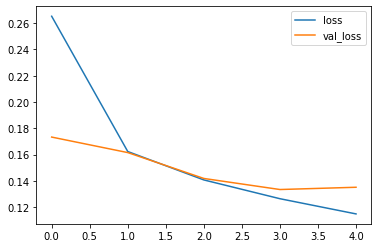

In [1218]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [1219]:
print(r.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


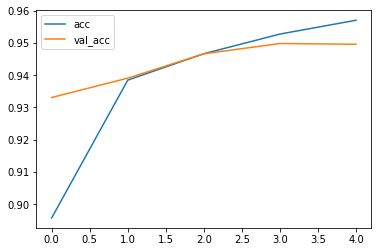

In [1220]:
#accuracies
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [1221]:
#plot the mean AUC over each model
p=model.predict(X_test)
aucs=[]
for j in range(7):
    auc=roc_auc_score(y_test[:,j],p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9666177314788426


In [1222]:
y_preds = model.predict(X_test)
y_pred_labels = [np.argmax(pred,axis=0) for pred in y_preds]

In [1223]:
y_test_labels=np.argmax(y_test,axis=1)

In [1224]:
len(X_test)

6763

========== Glove_CNN ==========

Accuracy on validation set: 0.8141
Precision on validation set: 0.8222
Recall on validation set: 0.7733
F1_Score on validation set: 0.7905

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.80      0.79       486
           1       0.83      0.76      0.79       807
           2       0.84      0.82      0.83      1993
           3       0.76      0.82      0.79      1619
           4       0.75      0.78      0.77       712
           5       0.89      0.52      0.66       126
           6       0.92      0.90      0.91      1020

    accuracy                           0.81      6763
   macro avg       0.82      0.77      0.79      6763
weighted avg       0.82      0.81      0.81      6763


Confusion Matrix : 
 [[ 391   36   21   16    4    7   11]
 [  39  615   56   81   14    1    1]
 [   8   49 1628  220   60    0   28]
 [  12   27  165 1327   62    0   26]
 [   9    7   52   76  557    

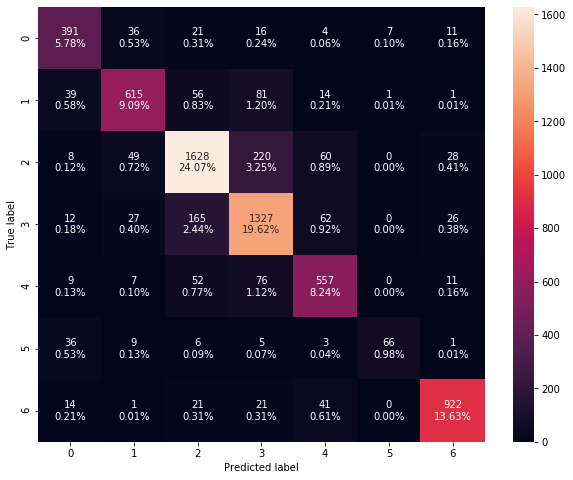

In [1225]:
results_glove_cnn = modelEvaluation(y_pred_labels,y_test_labels,'Glove_CNN')

# ALL MODEL RESULTS AND COMPARISON

In [1226]:
# showing all models result
dic = {
    'Metrics':['accuracy','precision','recall','f1-score','time detection'],
    'Logistic Regression' : results_lr,
    'SVM' : results_svc,
    'MultinomialNB' : results_gnb,
    'Random Forest' : results_rf,
    'LinearSVC' : results_lsvc,
    'Convolutional Nerual Network' : results_cnn,
    'Glove CNN' : results_glove_cnn,

}
metrics_df = pd.DataFrame(dic)

metrics_df = metrics_df.set_index('Metrics')
# displaying the DataFrame
print(tabulate(metrics_df, headers = 'keys', tablefmt = 'psql'))

+----------------+-----------------------+----------+-----------------+-----------------+-------------+--------------------------------+-------------+
| Metrics        |   Logistic Regression |      SVM |   MultinomialNB |   Random Forest |   LinearSVC |   Convolutional Nerual Network |   Glove CNN |
|----------------+-----------------------+----------+-----------------+-----------------+-------------+--------------------------------+-------------|
| accuracy       |              0.805686 | 0.80955  |        0.650566 |        0.779465 |    0.818107 |                       0.79533  |    0.814136 |
| precision      |              0.808147 | 0.815215 |        0.67915  |        0.827312 |    0.815316 |                       0.765349 |    0.822241 |
| recall         |              0.731478 | 0.731426 |        0.463192 |        0.655771 |    0.754263 |                       0.750338 |    0.773306 |
| f1-score       |              0.755366 | 0.753876 |        0.486092 |        0.680793 |    0

# SIDE BY SIDE COMPARISON OF THE PERFORMANCE METRICS

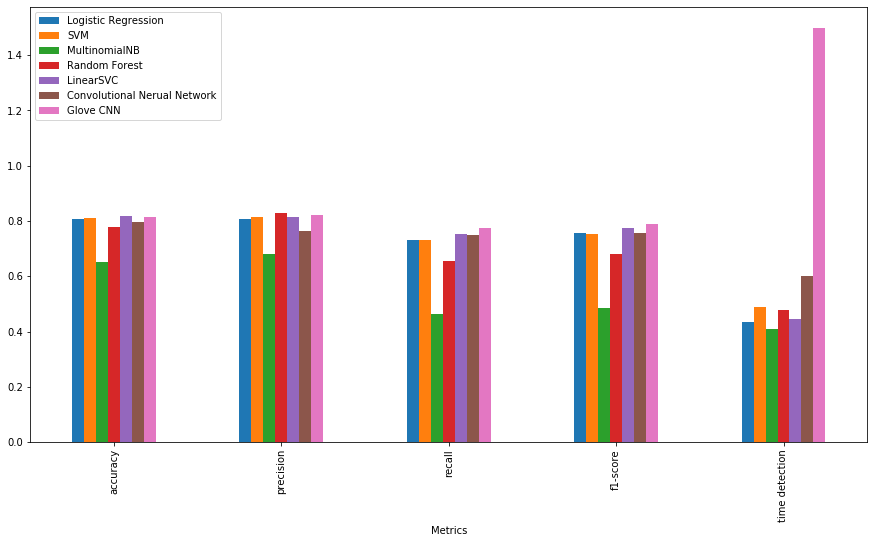

In [1227]:

metrics_df.plot(kind='bar', figsize=(15,8))
plt.show()

# Please note that the below accuracies are due to lower volume of data. When this was run with 100% data, the accuracies were higher. Please refer prashamsh_takkalapally_old for the older version.

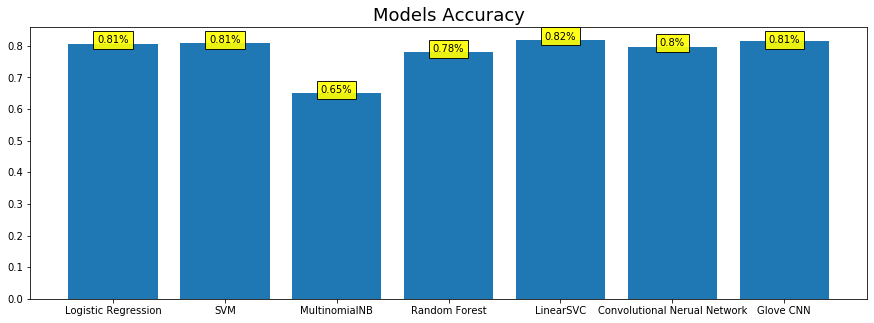

In [1228]:
models_acc = metrics_df.iloc[0].tolist()
models_names = metrics_df.columns.tolist()
plt.figure(figsize=(15,5))
plt.bar(models_names,models_acc)
plt.title("Models Accuracy", fontsize=18)

def addLabels(names,acc):
  for i in range(len(names)):
    plt.text(i,round(acc[i],2),f"{round(acc[i],2)}%", ha = 'center', bbox=dict(facecolor='yellow', alpha=0.9))

addLabels(models_names,models_acc)
plt.show()

# Naives Bayes classifier proved to be the worst performing out of all the algorithms. While SVM along with LinearSVC have performed the best with close to 87% accuracy. Logistic Regression performed well at 85%. CNN models would have performed better had we had more computational power and trained them on the entire dataset. Refer the testing results on unseen data in the section (SAVE MODEL TO PREDICT UNSEEN DATA).

# SVM IS THE WINNER WITH 87% ACCURACY AND BETTER PRECISION, RECALL AND PERFORMANCE METRICS
### REFER "SAVE MODEL TO PREDICT UNSEEN DATA USING SVC" SECTION for PREDICTIONS ON UNSEEN DATA

# NEXT STEPS:

#TRY RNN. RNN the activation outputs are propagated in both directions. It results in looping which provides a state to neurons giving it ability to remember the learnings. The CNN layer is replaced by bidirectional GRU layer


#TRY BERT. BERT is backed by Transformer and it’s core principle - attention, which understands the contextual relationship between different words. Rather than decoding the encoded information, BERT only encodes and generates a language model, so an encoder is enough. As compared to directional models such as RNN and LSTM which conceive each input sequentially (left to right or right to left). In fact, Transformer and BERT are non-directional - to be very precise, because both these models read the whole sentence as the input instead of sequential ordering. This characteristic allows models to learn the contextual information of a word with respect to all other words in the sentence. Also, unlike Glove BERT gives a contextual word embedding and yields more precise results.


#Data Preprocessing
 - Feed the POS tagging as a vector to see if it improves the accuracy
 - Use Cosine similarity as one of the distances to check if that improves the accuracy
 - Use different word embeddings including BERT, ELMO etc.
 - Create a customized stop words list
 - Cut down the length of the sentence for each algorithm to find the ideal size of the text for best accuracy

###### END########